In [1]:
ASSET = "XRPUSDT"
TARGET = "Close"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,0.8507,136976730.0,Extreme Fear,0.024995,0.046473,45.307315,22.522720,0.0245,0.0260,0.0259,-0.0001,0.511771,0.001543,-0.006479,0.862071,0.891464
2022-01-02,0.8586,129688032.0,Fear,0.009244,0.046456,46.415490,22.134504,0.0236,0.0295,0.0159,-0.0136,0.508931,0.001605,-0.009280,0.853300,0.893150
2022-01-03,0.8324,178618617.0,Fear,-0.030990,0.044825,43.283233,22.058970,-0.0474,0.0374,0.0001,-0.0373,0.502407,0.001551,-0.011456,0.839800,0.889764
2022-01-04,0.8228,214415744.0,Extreme Fear,-0.011600,0.038926,42.160554,22.666112,-0.1239,0.0662,0.0132,-0.0530,0.486053,0.001525,-0.011492,0.835700,0.880914
2022-01-05,0.7726,370612510.0,Extreme Fear,-0.062952,0.040992,36.787156,24.113538,-0.1811,0.1280,0.0145,-0.1135,0.468132,0.001636,-0.012187,0.829343,0.867979


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:39,475] A new study created in memory with name: no-name-e2f34b6a-5225-4d2e-90a0-e0d9623b0125


Epoch 1/22


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0214 - val_loss: 0.0407
Epoch 2/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0331
Epoch 3/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0335
Epoch 4/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0357
Epoch 5/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0376
Epoch 6/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0323
Epoch 7/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0342
Epoch 8/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0344
Epoch 9/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 0.0353
Epoch 10/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0355
Epoch 11/22
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0375
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[I 2025-05-09 19:33:45,074] Trial 0 finished with value: 0.18854561097359393 and parameters: {'units_l0': 98, 'dropout_l0': 0.37891150653583133, 'learning_rate': 0.008523657644174886, 'batch_size': 32, 'max_epochs': 22, 'sequence_length': 13}. Best is trial 0 with value: 0.18854561097359393.


Epoch 1/15


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0105 - val_loss: 0.0276
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1213e-04 - val_loss: 0.0148
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4149e-04 - val_loss: 0.0086
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8349e-04 - val_loss: 0.0098
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6327e-04 - val_loss: 0.0089
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1550e-04 - val_loss: 0.0061
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7191e-04 - val_loss: 0.0066
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5814e-04 - val_loss: 0.0067
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2614e-04 - val_loss: 0.0059
Epoch 10/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4011e-04 - val_loss: 0.0050
Epoch 11/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7729e-04 - val_loss: 0.0060
Epoch 12/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9

[I 2025-05-09 19:33:55,586] Trial 1 finished with value: 0.02584363948180473 and parameters: {'units_l0': 129, 'dropout_l0': 0.022435028069106022, 'learning_rate': 0.00041553596956760076, 'batch_size': 16, 'max_epochs': 15, 'sequence_length': 14}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/71


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0085 - val_loss: 0.0861
Epoch 2/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0044 - val_loss: 0.0794
Epoch 3/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031 - val_loss: 0.0775
Epoch 4/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0029 - val_loss: 0.0716
Epoch 5/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025 - val_loss: 0.0685
Epoch 6/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - val_loss: 0.0630
Epoch 7/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 0.0584
Epoch 8/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0539
Epoch 9/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 0.0480
Epoch 10/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9947e-04 - val_loss: 0.0444
Epoch 11/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.9307e-04 - val_loss: 0.0400
Epoch 12/71
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.1675

[I 2025-05-09 19:34:45,863] Trial 2 finished with value: 0.09384879364278047 and parameters: {'units_l0': 97, 'dropout_l0': 0.0202101609034136, 'learning_rate': 2.7156473585967858e-05, 'batch_size': 16, 'max_epochs': 71, 'sequence_length': 52}. Best is trial 1 with value: 0.02584363948180473.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0239 - val_loss: 0.0624
Epoch 2/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0023 - val_loss: 0.0434
Epoch 3/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 0.0258
Epoch 4/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3107e-04 - val_loss: 0.0205
Epoch 5/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0466e-04 - val_loss: 0.0220
Epoch 6/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8508e-04 - val_loss: 0.0166
Epoch 7/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8975e-04 - val_loss: 0.0203
Epoch 8/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1754e-04 - val_loss: 0.0161
Epoch 9/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.5380e-04 - val_loss: 0.0168
Epoch 10/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4171e-04 - val_loss: 0.0176
Epoch 11/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5087e-04 - val_loss: 0.0173
Epoch 12/75
54/54 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-05-09 19:35:01,647] Trial 3 finished with value: 0.07683489248608548 and parameters: {'units_l0': 52, 'dropout_l0': 0.11254236404728868, 'learning_rate': 0.0006896487734081665, 'batch_size': 16, 'max_epochs': 75, 'sequence_length': 23}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/11


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0044 - val_loss: 0.0205
Epoch 2/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0203
Epoch 3/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 0.0197
Epoch 4/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0233
Epoch 5/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 0.0214
Epoch 6/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 0.0200
Epoch 7/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0228
Epoch 8/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 0.0196
Epoch 9/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 0.0186
Epoch 10/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 0.0234
Epoch 11/11
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0224
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


[I 2025-05-09 19:35:12,161] Trial 4 finished with value: 0.10851263081652113 and parameters: {'units_l0': 178, 'dropout_l0': 0.418873882462132, 'learning_rate': 0.00021147066551749108, 'batch_size': 32, 'max_epochs': 11, 'sequence_length': 10}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/37


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0229 - val_loss: 0.0382
Epoch 2/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0409
Epoch 3/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0374
Epoch 4/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 0.0355
Epoch 5/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 0.0356
Epoch 6/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 0.0295
Epoch 7/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0314
Epoch 8/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0316
Epoch 9/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 0.0282
Epoch 10/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 0.0333
Epoch 11/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0315
Epoch 12/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_l

[I 2025-05-09 19:35:24,411] Trial 5 finished with value: 0.15883868978755103 and parameters: {'units_l0': 52, 'dropout_l0': 0.46719937365719716, 'learning_rate': 0.000640479683356824, 'batch_size': 32, 'max_epochs': 37, 'sequence_length': 23}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/26


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0434 - val_loss: 0.1940
Epoch 2/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0350 - val_loss: 0.1745
Epoch 3/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0288 - val_loss: 0.1575
Epoch 4/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0214 - val_loss: 0.1432
Epoch 5/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0180 - val_loss: 0.1311
Epoch 6/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0144 - val_loss: 0.1210
Epoch 7/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0116 - val_loss: 0.1127
Epoch 8/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0106 - val_loss: 0.1054
Epoch 9/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0082 - val_loss: 0.0999
Epoch 10/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0072 - val_loss: 0.0955
Epoch 11/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0065 - val_loss: 0.0915
Epoch 12/26
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0059 - val_l

[I 2025-05-09 19:35:45,278] Trial 6 finished with value: 0.395020459505741 and parameters: {'units_l0': 97, 'dropout_l0': 0.06421138193293918, 'learning_rate': 1.3581332888104481e-05, 'batch_size': 64, 'max_epochs': 26, 'sequence_length': 47}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/41


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.1718 - val_loss: 0.0526
Epoch 2/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - val_loss: 0.0294
Epoch 3/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.5735e-04 - val_loss: 0.0179
Epoch 4/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.1520e-04 - val_loss: 0.0129
Epoch 5/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.4516e-04 - val_loss: 0.0157
Epoch 6/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.0403e-04 - val_loss: 0.0128
Epoch 7/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.4410e-04 - val_loss: 0.0121
Epoch 8/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.7999e-04 - val_loss: 0.0134
Epoch 9/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.4815e-04 - val_loss: 0.0148
Epoch 10/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.0699e-04 - val_loss: 0.0139
Epoch 11/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.3007e-04 - val_loss: 0.0129
Epoch 12/41
27/27 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:36:02,365] Trial 7 finished with value: 0.07094329337576158 and parameters: {'units_l0': 182, 'dropout_l0': 0.10536179923092354, 'learning_rate': 0.009718322516233181, 'batch_size': 32, 'max_epochs': 41, 'sequence_length': 25}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/24


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0215 - val_loss: 0.0550
Epoch 2/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0091 - val_loss: 0.0543
Epoch 3/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0056 - val_loss: 0.0502
Epoch 4/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0040 - val_loss: 0.0492
Epoch 5/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0034 - val_loss: 0.0502
Epoch 6/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0029 - val_loss: 0.0474
Epoch 7/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023 - val_loss: 0.0464
Epoch 8/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021 - val_loss: 0.0436
Epoch 9/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0019 - val_loss: 0.0420
Epoch 10/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018 - val_loss: 0.0391
Epoch 11/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0017 - val_loss: 0.0381
Epoch 12/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015 - val_l

[I 2025-05-09 19:36:34,573] Trial 8 finished with value: 0.1549779851575727 and parameters: {'units_l0': 150, 'dropout_l0': 0.39499184027045664, 'learning_rate': 3.48557526178091e-05, 'batch_size': 32, 'max_epochs': 24, 'sequence_length': 41}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/17


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0121 - val_loss: 0.0716
Epoch 2/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028 - val_loss: 0.0382
Epoch 3/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 0.0240
Epoch 4/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0150
Epoch 5/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.4201e-04 - val_loss: 0.0106
Epoch 6/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8082e-04 - val_loss: 0.0076
Epoch 7/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1380e-04 - val_loss: 0.0074
Epoch 8/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9706e-04 - val_loss: 0.0064
Epoch 9/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9145e-04 - val_loss: 0.0046
Epoch 10/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3200e-04 - val_loss: 0.0063
Epoch 11/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2782e-04 - val_loss: 0.0066
Epoch 12/17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step -

[I 2025-05-09 19:36:49,161] Trial 9 finished with value: 0.027153577488752925 and parameters: {'units_l0': 70, 'dropout_l0': 0.09000388946303534, 'learning_rate': 0.00018906739613798029, 'batch_size': 16, 'max_epochs': 17, 'sequence_length': 11}. Best is trial 1 with value: 0.02584363948180473.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0285 - val_loss: 0.0784
Epoch 2/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0045 - val_loss: 0.0533
Epoch 3/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0026 - val_loss: 0.0289
Epoch 4/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0015 - val_loss: 0.0251
Epoch 5/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0029 - val_loss: 0.0422
Epoch 6/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0015 - val_loss: 0.0367
Epoch 7/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0011 - val_loss: 0.0267
Epoch 8/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 7.9689e-04 - val_loss: 0.0249
Epoch 9/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 7.3567e-04 - val_loss: 0.0255
Epoch 10/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 7.4570e-04 - val_loss: 0.0242
Epoch 11/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 5.9657e-04 - val_loss: 0.0215
Epoch 12/51
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms

[I 2025-05-09 19:37:14,799] Trial 10 finished with value: 0.12092685760328861 and parameters: {'units_l0': 139, 'dropout_l0': 0.24138544550654628, 'learning_rate': 0.001841702750215611, 'batch_size': 64, 'max_epochs': 51, 'sequence_length': 60}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/15


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0092 - val_loss: 0.0309
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 0.0206
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0133
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1030e-04 - val_loss: 0.0113
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8072e-04 - val_loss: 0.0109
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5868e-04 - val_loss: 0.0102
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3786e-04 - val_loss: 0.0112
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1772e-04 - val_loss: 0.0096
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.2868e-04 - val_loss: 0.0099
Epoch 10/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.7528e-04 - val_loss: 0.0107
Epoch 11/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7076e-04 - val_loss: 0.0110
Epoch 12/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:37:31,214] Trial 11 finished with value: 0.05614226567238551 and parameters: {'units_l0': 111, 'dropout_l0': 0.18888730520253597, 'learning_rate': 0.00012682914279839487, 'batch_size': 16, 'max_epochs': 15, 'sequence_length': 16}. Best is trial 1 with value: 0.02584363948180473.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0403 - val_loss: 0.0907
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065 - val_loss: 0.0770
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0622
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 0.0513
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0432
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 0.0379
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0345
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.9706e-04 - val_loss: 0.0304
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0283
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.9113e-04 - val_loss: 0.0252
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2799e-04 - val_loss: 0.0257
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-09 19:38:00,976] Trial 12 finished with value: 0.10616419519293997 and parameters: {'units_l0': 71, 'dropout_l0': 0.1744891996647288, 'learning_rate': 8.782908180306611e-05, 'batch_size': 16, 'max_epochs': 100, 'sequence_length': 32}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/36


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0083 - val_loss: 0.0151
Epoch 2/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.5705e-04 - val_loss: 0.0123
Epoch 3/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4801e-04 - val_loss: 0.0086
Epoch 4/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4477e-04 - val_loss: 0.0091
Epoch 5/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5242e-04 - val_loss: 0.0089
Epoch 6/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.6098e-04 - val_loss: 0.0060
Epoch 7/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8755e-04 - val_loss: 0.0069
Epoch 8/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1905e-04 - val_loss: 0.0069
Epoch 9/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.0821e-04 - val_loss: 0.0066
Epoch 10/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.1094e-04 - val_loss: 0.0054
Epoch 11/36
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7297e-04 - val_loss: 0.0054
Epoch 12/36
55/55 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:38:19,364] Trial 13 finished with value: 0.02956084917614713 and parameters: {'units_l0': 152, 'dropout_l0': 0.021829761810652517, 'learning_rate': 0.000513917351594282, 'batch_size': 16, 'max_epochs': 36, 'sequence_length': 18}. Best is trial 1 with value: 0.02584363948180473.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0176 - val_loss: 0.0238
Epoch 2/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0191
Epoch 3/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 0.0215
Epoch 4/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 0.0248
Epoch 5/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 0.0281
Epoch 6/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 0.0213
Epoch 7/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6255e-04 - val_loss: 0.0175
Epoch 8/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0281
Epoch 9/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.9967e-04 - val_loss: 0.0275
Epoch 10/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 0.0412
Epoch 11/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0279
Epoch 12/61
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - l

[I 2025-05-09 19:38:39,568] Trial 14 finished with value: 0.10215958462746541 and parameters: {'units_l0': 122, 'dropout_l0': 0.3106869372884758, 'learning_rate': 0.0016705524559751518, 'batch_size': 16, 'max_epochs': 61, 'sequence_length': 32}. Best is trial 1 with value: 0.02584363948180473.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0147 - val_loss: 0.0929
Epoch 2/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040 - val_loss: 0.0544
Epoch 3/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0365
Epoch 4/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 0.0248
Epoch 5/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0181
Epoch 6/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.5993e-04 - val_loss: 0.0148
Epoch 7/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.1954e-04 - val_loss: 0.0113
Epoch 8/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.2157e-04 - val_loss: 0.0094
Epoch 9/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6670e-04 - val_loss: 0.0091
Epoch 10/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.5804e-04 - val_loss: 0.0071
Epoch 11/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7736e-04 - val_loss: 0.0076
Epoch 12/13
55/55 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-09 19:38:53,065] Trial 15 finished with value: 0.041273266373239505 and parameters: {'units_l0': 82, 'dropout_l0': 0.10827276894045891, 'learning_rate': 6.692594880289838e-05, 'batch_size': 16, 'max_epochs': 13, 'sequence_length': 20}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/49


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0236 - val_loss: 0.0409
Epoch 2/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 0.0228
Epoch 3/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.9801e-04 - val_loss: 0.0123
Epoch 4/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4544e-04 - val_loss: 0.0118
Epoch 5/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.5698e-04 - val_loss: 0.0110
Epoch 6/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6614e-04 - val_loss: 0.0125
Epoch 7/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7892e-04 - val_loss: 0.0122
Epoch 8/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.2173e-04 - val_loss: 0.0125
Epoch 9/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4132e-04 - val_loss: 0.0097
Epoch 10/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4603e-04 - val_loss: 0.0121
Epoch 11/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.5881e-04 - val_loss: 0.0106
Epoch 12/49
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8

[I 2025-05-09 19:39:04,962] Trial 16 finished with value: 0.05684226838570433 and parameters: {'units_l0': 131, 'dropout_l0': 0.16551663426927887, 'learning_rate': 0.0002870222761970893, 'batch_size': 16, 'max_epochs': 49, 'sequence_length': 10}. Best is trial 1 with value: 0.02584363948180473.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0196 - val_loss: 0.0994
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0044 - val_loss: 0.0634
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0025 - val_loss: 0.0488
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0022 - val_loss: 0.0378
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0017 - val_loss: 0.0326
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0014 - val_loss: 0.0278
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0013 - val_loss: 0.0231
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0216
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0010 - val_loss: 0.0212
Epoch 10/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 9.4163e-04 - val_loss: 0.0192
Epoch 11/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0011 - val_loss: 0.0186
Epoch 12/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss

[I 2025-05-09 19:39:31,101] Trial 17 finished with value: 0.09025793261859039 and parameters: {'units_l0': 165, 'dropout_l0': 0.27484933809513146, 'learning_rate': 0.00016583421359222695, 'batch_size': 64, 'max_epochs': 30, 'sequence_length': 29}. Best is trial 1 with value: 0.02584363948180473.


Epoch 1/95


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0058 - val_loss: 0.0098
Epoch 2/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2382e-04 - val_loss: 0.0108
Epoch 3/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6961e-04 - val_loss: 0.0090
Epoch 4/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9026e-04 - val_loss: 0.0091
Epoch 5/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5173e-04 - val_loss: 0.0059
Epoch 6/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1842e-04 - val_loss: 0.0055
Epoch 7/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8718e-04 - val_loss: 0.0073
Epoch 8/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6927e-04 - val_loss: 0.0060
Epoch 9/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2429e-04 - val_loss: 0.0049
Epoch 10/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5990e-04 - val_loss: 0.0035
Epoch 11/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2893e-04 - val_loss: 0.0038
Epoch 12/95
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:39:46,244] Trial 18 finished with value: 0.01863138682893278 and parameters: {'units_l0': 73, 'dropout_l0': 0.008651170990926008, 'learning_rate': 0.0018932036023989014, 'batch_size': 16, 'max_epochs': 95, 'sequence_length': 15}. Best is trial 18 with value: 0.01863138682893278.


Epoch 1/96


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0200 - val_loss: 0.0204
Epoch 2/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4936e-04 - val_loss: 0.0136
Epoch 3/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.5477e-04 - val_loss: 0.0105
Epoch 4/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.3244e-04 - val_loss: 0.0106
Epoch 5/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.6855e-04 - val_loss: 0.0100
Epoch 6/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5472e-04 - val_loss: 0.0089
Epoch 7/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7680e-04 - val_loss: 0.0075
Epoch 8/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7274e-04 - val_loss: 0.0088
Epoch 9/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.1147e-04 - val_loss: 0.0075
Epoch 10/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7859e-04 - val_loss: 0.0058
Epoch 11/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9162e-04 - val_loss: 0.0063
Epoch 12/96
54/54 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:40:08,879] Trial 19 finished with value: 0.03367532212926479 and parameters: {'units_l0': 115, 'dropout_l0': 0.018468163354497635, 'learning_rate': 0.002996487807337712, 'batch_size': 16, 'max_epochs': 96, 'sequence_length': 38}. Best is trial 18 with value: 0.01863138682893278.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0489 - val_loss: 0.0784
Epoch 2/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031 - val_loss: 0.0585
Epoch 3/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015 - val_loss: 0.0299
Epoch 4/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.9063e-04 - val_loss: 0.0209
Epoch 5/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.3098e-04 - val_loss: 0.0181
Epoch 6/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.6936e-04 - val_loss: 0.0161
Epoch 7/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.1312e-04 - val_loss: 0.0140
Epoch 8/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.7336e-04 - val_loss: 0.0147
Epoch 9/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.2073e-04 - val_loss: 0.0147
Epoch 10/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.3529e-04 - val_loss: 0.0121
Epoch 11/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.0327e-04 - val_loss: 0.0119
Epoch 12/88
14/14 ━━━━━━━━━━━━━

[I 2025-05-09 19:40:23,892] Trial 20 finished with value: 0.05235023452716167 and parameters: {'units_l0': 80, 'dropout_l0': 0.057359733584024075, 'learning_rate': 0.003853869685160326, 'batch_size': 64, 'max_epochs': 88, 'sequence_length': 16}. Best is trial 18 with value: 0.01863138682893278.


Epoch 1/63


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0059 - val_loss: 0.0168
Epoch 2/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6089e-04 - val_loss: 0.0129
Epoch 3/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7715e-04 - val_loss: 0.0089
Epoch 4/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7899e-04 - val_loss: 0.0075
Epoch 5/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2153e-04 - val_loss: 0.0073
Epoch 6/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5030e-04 - val_loss: 0.0077
Epoch 7/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4440e-04 - val_loss: 0.0082
Epoch 8/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5759e-04 - val_loss: 0.0063
Epoch 9/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2916e-04 - val_loss: 0.0058
Epoch 10/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6499e-04 - val_loss: 0.0055
Epoch 11/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5725e-04 - val_loss: 0.0051
Epoch 12/63
55/55 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-09 19:40:45,210] Trial 21 finished with value: 0.014842467053902266 and parameters: {'units_l0': 62, 'dropout_l0': 0.0036857237994084163, 'learning_rate': 0.0012350486609175192, 'batch_size': 16, 'max_epochs': 63, 'sequence_length': 15}. Best is trial 21 with value: 0.014842467053902266.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0219 - val_loss: 0.0331
Epoch 2/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.5739e-04 - val_loss: 0.0165
Epoch 3/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3257e-04 - val_loss: 0.0137
Epoch 4/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5512e-04 - val_loss: 0.0113
Epoch 5/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9462e-04 - val_loss: 0.0127
Epoch 6/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6564e-04 - val_loss: 0.0113
Epoch 7/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4072e-04 - val_loss: 0.0127
Epoch 8/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6851e-04 - val_loss: 0.0102
Epoch 9/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3487e-04 - val_loss: 0.0102
Epoch 10/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2662e-04 - val_loss: 0.0111
Epoch 11/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6746e-04 - val_loss: 0.0119
Epoch 12/80
54/54 ━━━━━

[I 2025-05-09 19:41:05,206] Trial 22 finished with value: 0.046385096575347055 and parameters: {'units_l0': 67, 'dropout_l0': 0.006770901764101198, 'learning_rate': 0.001096974795314184, 'batch_size': 16, 'max_epochs': 80, 'sequence_length': 28}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/66


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0259 - val_loss: 0.0326
Epoch 2/66
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2782e-04 - val_loss: 0.0163
Epoch 3/66
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6243e-04 - val_loss: 0.0106
Epoch 4/66
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 0.0119
Epoch 5/66
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7237e-04 - val_loss: 0.0113
Epoch 6/66
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4844e-04 - val_loss: 0.0110
Epoch 7/66
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6779e-04 - val_loss: 0.0107
Epoch 8/66
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9914e-04 - val_loss: 0.0125
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-05-09 19:41:13,913] Trial 23 finished with value: 0.06219416853689897 and parameters: {'units_l0': 86, 'dropout_l0': 0.06223717184436536, 'learning_rate': 0.0041629980225545, 'batch_size': 16, 'max_epochs': 66, 'sequence_length': 19}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/88


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0128 - val_loss: 0.0321
Epoch 2/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 0.0136
Epoch 3/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.6446e-04 - val_loss: 0.0115
Epoch 4/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0072e-04 - val_loss: 0.0114
Epoch 5/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5536e-04 - val_loss: 0.0139
Epoch 6/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7305e-04 - val_loss: 0.0153
Epoch 7/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2334e-04 - val_loss: 0.0134
Epoch 8/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8935e-04 - val_loss: 0.0128
Epoch 9/88
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2233e-04 - val_loss: 0.0120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-05-09 19:41:25,775] Trial 24 finished with value: 0.06650705469059003 and parameters: {'units_l0': 59, 'dropout_l0': 0.1305730445874962, 'learning_rate': 0.00045572071197710445, 'batch_size': 16, 'max_epochs': 88, 'sequence_length': 14}. Best is trial 21 with value: 0.014842467053902266.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0080 - val_loss: 0.0190
Epoch 2/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7580e-04 - val_loss: 0.0118
Epoch 3/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5299e-04 - val_loss: 0.0090
Epoch 4/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 0.0150
Epoch 5/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6480e-04 - val_loss: 0.0131
Epoch 6/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1576e-04 - val_loss: 0.0125
Epoch 7/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9728e-04 - val_loss: 0.0093
Epoch 8/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8799e-04 - val_loss: 0.0089
Epoch 9/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5218e-04 - val_loss: 0.0127
Epoch 10/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8119e-04 - val_loss: 0.0122
Epoch 11/59
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6269e-04 - val_loss: 0.0105
Epoch 12/59
55/55 ━━━━━━━━━

[I 2025-05-09 19:41:41,572] Trial 25 finished with value: 0.05183575020058827 and parameters: {'units_l0': 107, 'dropout_l0': 0.05777190890115513, 'learning_rate': 0.0010903309860337885, 'batch_size': 16, 'max_epochs': 59, 'sequence_length': 20}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/46


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0202 - val_loss: 0.0110
Epoch 2/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.8281e-04 - val_loss: 0.0085
Epoch 3/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.4262e-04 - val_loss: 0.0077
Epoch 4/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6062e-04 - val_loss: 0.0068
Epoch 5/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.6319e-04 - val_loss: 0.0063
Epoch 6/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5109e-04 - val_loss: 0.0041
Epoch 7/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3501e-04 - val_loss: 0.0062
Epoch 8/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9055e-04 - val_loss: 0.0052
Epoch 9/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6649e-04 - val_loss: 0.0040
Epoch 10/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4400e-04 - val_loss: 0.0057
Epoch 11/46
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0705e-04 - val_loss: 0.0047
Epoch 12/46
54/54 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:42:03,160] Trial 26 finished with value: 0.023092274192303055 and parameters: {'units_l0': 195, 'dropout_l0': 0.006184211688679641, 'learning_rate': 0.002086223355397687, 'batch_size': 16, 'max_epochs': 46, 'sequence_length': 27}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/47


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0235 - val_loss: 0.0358
Epoch 2/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.8839e-04 - val_loss: 0.0163
Epoch 3/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.1800e-04 - val_loss: 0.0145
Epoch 4/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.8086e-04 - val_loss: 0.0130
Epoch 5/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.0622e-04 - val_loss: 0.0167
Epoch 6/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2608e-04 - val_loss: 0.0181
Epoch 7/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.0191e-04 - val_loss: 0.0127
Epoch 8/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3421e-04 - val_loss: 0.0135
Epoch 9/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.3883e-04 - val_loss: 0.0178
Epoch 10/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.1741e-04 - val_loss: 0.0165
Epoch 11/47
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.4654e-04 - val_loss: 0.0185
Epoch 12/47
54/54 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:42:22,361] Trial 27 finished with value: 0.0741745276259141 and parameters: {'units_l0': 161, 'dropout_l0': 0.23080825441144368, 'learning_rate': 0.0018958752249591143, 'batch_size': 16, 'max_epochs': 47, 'sequence_length': 26}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/85


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0183 - val_loss: 0.0561
Epoch 2/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0030 - val_loss: 0.0328
Epoch 3/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0011 - val_loss: 0.0221
Epoch 4/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.7021e-04 - val_loss: 0.0170
Epoch 5/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 6.9006e-04 - val_loss: 0.0141
Epoch 6/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 5.4841e-04 - val_loss: 0.0139
Epoch 7/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.0205e-04 - val_loss: 0.0138
Epoch 8/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 6.9049e-04 - val_loss: 0.0108
Epoch 9/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.9942e-04 - val_loss: 0.0122
Epoch 10/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.0827e-04 - val_loss: 0.0137
Epoch 11/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.6972e-04 - val_loss: 0.0112
Epoch 12/85
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s

[I 2025-05-09 19:42:47,467] Trial 28 finished with value: 0.06043758653546672 and parameters: {'units_l0': 196, 'dropout_l0': 0.1467863797594418, 'learning_rate': 0.0010812970413192128, 'batch_size': 64, 'max_epochs': 85, 'sequence_length': 36}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/66


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0543 - val_loss: 0.0278
Epoch 2/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - val_loss: 0.0246
Epoch 3/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 0.0208
Epoch 4/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 0.0167
Epoch 5/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0245
Epoch 6/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 0.0297
Epoch 7/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 0.0242
Epoch 8/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 0.0296
Epoch 9/66
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0210
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[I 2025-05-09 19:43:04,122] Trial 29 finished with value: 0.09760097989684281 and parameters: {'units_l0': 199, 'dropout_l0': 0.32884812871215185, 'learning_rate': 0.0028323736444548562, 'batch_size': 16, 'max_epochs': 66, 'sequence_length': 31}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/55


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0654 - val_loss: 0.0522
Epoch 2/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0296
Epoch 3/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.9900e-04 - val_loss: 0.0224
Epoch 4/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.7316e-04 - val_loss: 0.0174
Epoch 5/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.6189e-04 - val_loss: 0.0175
Epoch 6/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5926e-04 - val_loss: 0.0178
Epoch 7/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.0197e-04 - val_loss: 0.0186
Epoch 8/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.4301e-04 - val_loss: 0.0181
Epoch 9/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.9124e-04 - val_loss: 0.0185
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-05-09 19:43:12,934] Trial 30 finished with value: 0.1016703789117256 and parameters: {'units_l0': 88, 'dropout_l0': 0.1997508643312384, 'learning_rate': 0.005721891000371802, 'batch_size': 32, 'max_epochs': 55, 'sequence_length': 23}. Best is trial 21 with value: 0.014842467053902266.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0154 - val_loss: 0.0313
Epoch 2/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 0.0141
Epoch 3/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4051e-04 - val_loss: 0.0102
Epoch 4/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2621e-04 - val_loss: 0.0096
Epoch 5/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6239e-04 - val_loss: 0.0070
Epoch 6/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1246e-04 - val_loss: 0.0075
Epoch 7/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9028e-04 - val_loss: 0.0059
Epoch 8/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5635e-04 - val_loss: 0.0056
Epoch 9/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7277e-04 - val_loss: 0.0060
Epoch 10/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2704e-04 - val_loss: 0.0049
Epoch 11/42
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9294e-04 - val_loss: 0.0050
Epoch 12/42
55/55 ━━━━━━━━━

[I 2025-05-09 19:43:32,621] Trial 31 finished with value: 0.01813722941682551 and parameters: {'units_l0': 134, 'dropout_l0': 0.0032513958671749887, 'learning_rate': 0.0003462271031436111, 'batch_size': 16, 'max_epochs': 42, 'sequence_length': 14}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/44


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0097 - val_loss: 0.0127
Epoch 2/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6047e-04 - val_loss: 0.0080
Epoch 3/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4918e-04 - val_loss: 0.0096
Epoch 4/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3117e-04 - val_loss: 0.0084
Epoch 5/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.9105e-04 - val_loss: 0.0089
Epoch 6/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.6703e-04 - val_loss: 0.0069
Epoch 7/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2459e-04 - val_loss: 0.0062
Epoch 8/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3134e-04 - val_loss: 0.0056
Epoch 9/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3261e-04 - val_loss: 0.0055
Epoch 10/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7449e-04 - val_loss: 0.0061
Epoch 11/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.8844e-04 - val_loss: 0.0046
Epoch 12/44
55/55 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:43:56,282] Trial 32 finished with value: 0.023547069050986125 and parameters: {'units_l0': 182, 'dropout_l0': 0.04796133912609775, 'learning_rate': 0.0009335367674988776, 'batch_size': 16, 'max_epochs': 44, 'sequence_length': 14}. Best is trial 21 with value: 0.014842467053902266.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0844 - val_loss: 0.0215
Epoch 2/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1185e-04 - val_loss: 0.0079
Epoch 3/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8685e-04 - val_loss: 0.0085
Epoch 4/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5525e-04 - val_loss: 0.0069
Epoch 5/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4713e-04 - val_loss: 0.0058
Epoch 6/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6753e-04 - val_loss: 0.0070
Epoch 7/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1872e-04 - val_loss: 0.0061
Epoch 8/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8237e-04 - val_loss: 0.0050
Epoch 9/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3425e-04 - val_loss: 0.0060
Epoch 10/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0918e-04 - val_loss: 0.0051
Epoch 11/34
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5553e-04 - val_loss: 0.0064
Epoch 12/34
55/55 ━━━━━

[I 2025-05-09 19:44:17,075] Trial 33 finished with value: 0.025017294818770987 and parameters: {'units_l0': 143, 'dropout_l0': 0.002952078828709301, 'learning_rate': 0.005606762007988945, 'batch_size': 16, 'max_epochs': 34, 'sequence_length': 17}. Best is trial 21 with value: 0.014842467053902266.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0059 - val_loss: 0.0138
Epoch 2/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3022e-04 - val_loss: 0.0107
Epoch 3/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1882e-04 - val_loss: 0.0073
Epoch 4/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6289e-04 - val_loss: 0.0089
Epoch 5/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3892e-04 - val_loss: 0.0097
Epoch 6/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.7904e-04 - val_loss: 0.0113
Epoch 7/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6333e-04 - val_loss: 0.0070
Epoch 8/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0061e-04 - val_loss: 0.0087
Epoch 9/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0877e-04 - val_loss: 0.0045
Epoch 10/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4766e-04 - val_loss: 0.0073
Epoch 11/55
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4912e-04 - val_loss: 0.0081
Epoch 12/55
55/55 ━━━━━━━

[I 2025-05-09 19:44:29,979] Trial 34 finished with value: 0.02616016132536496 and parameters: {'units_l0': 62, 'dropout_l0': 0.03790107390473103, 'learning_rate': 0.0014405448493978478, 'batch_size': 16, 'max_epochs': 55, 'sequence_length': 21}. Best is trial 21 with value: 0.014842467053902266.


Epoch 1/76


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0120 - val_loss: 0.0096
Epoch 2/76
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7821e-04 - val_loss: 0.0096
Epoch 3/76
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5552e-04 - val_loss: 0.0069
Epoch 4/76
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2139e-04 - val_loss: 0.0078
Epoch 5/76
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4179e-04 - val_loss: 0.0092
Epoch 6/76
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6534e-04 - val_loss: 0.0117
Epoch 7/76
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3934e-04 - val_loss: 0.0086
Epoch 8/76
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0380e-04 - val_loss: 0.0120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2025-05-09 19:44:40,680] Trial 35 finished with value: 0.040451547096364344 and parameters: {'units_l0': 98, 'dropout_l0': 0.08492021902768371, 'learning_rate': 0.0026543474437283054, 'batch_size': 16, 'max_epochs': 76, 'sequence_length': 13}. Best is trial 21 with value: 0.014842467053902266.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0074 - val_loss: 0.0230
Epoch 2/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3268e-04 - val_loss: 0.0146
Epoch 3/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3117e-04 - val_loss: 0.0119
Epoch 4/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8038e-04 - val_loss: 0.0086
Epoch 5/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7663e-04 - val_loss: 0.0071
Epoch 6/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.0831e-04 - val_loss: 0.0077
Epoch 7/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6272e-04 - val_loss: 0.0069
Epoch 8/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4249e-04 - val_loss: 0.0059
Epoch 9/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7364e-04 - val_loss: 0.0049
Epoch 10/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4026e-04 - val_loss: 0.0048
Epoch 11/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2328e-04 - val_loss: 0.0037
Epoch 12/44
55/55 ━━━━━━

[I 2025-05-09 19:45:01,263] Trial 36 finished with value: 0.013244397478554892 and parameters: {'units_l0': 169, 'dropout_l0': 0.001739925093700568, 'learning_rate': 0.0007421005077914572, 'batch_size': 16, 'max_epochs': 44, 'sequence_length': 12}. Best is trial 36 with value: 0.013244397478554892.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0058 - val_loss: 0.0111
Epoch 2/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8086e-04 - val_loss: 0.0077
Epoch 3/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6254e-04 - val_loss: 0.0091
Epoch 4/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2001e-04 - val_loss: 0.0062
Epoch 5/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9926e-04 - val_loss: 0.0079
Epoch 6/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7452e-04 - val_loss: 0.0053
Epoch 7/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0109e-04 - val_loss: 0.0045
Epoch 8/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2502e-04 - val_loss: 0.0044
Epoch 9/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8946e-04 - val_loss: 0.0052
Epoch 10/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8535e-04 - val_loss: 0.0055
Epoch 11/39
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4496e-04 - val_loss: 0.0046
Epoch 12/39
55/55 ━━━━━

[I 2025-05-09 19:45:15,957] Trial 37 finished with value: 0.0258757921691883 and parameters: {'units_l0': 170, 'dropout_l0': 0.03539273371471735, 'learning_rate': 0.0005789015294070173, 'batch_size': 16, 'max_epochs': 39, 'sequence_length': 12}. Best is trial 36 with value: 0.013244397478554892.


Epoch 1/29


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0074 - val_loss: 0.0273
Epoch 2/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 0.0131
Epoch 3/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.5500e-04 - val_loss: 0.0074
Epoch 4/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0711e-04 - val_loss: 0.0064
Epoch 5/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3205e-04 - val_loss: 0.0071
Epoch 6/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1734e-04 - val_loss: 0.0064
Epoch 7/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0284e-04 - val_loss: 0.0065
Epoch 8/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8526e-04 - val_loss: 0.0074
Epoch 9/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0823e-04 - val_loss: 0.0065
Epoch 10/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7013e-04 - val_loss: 0.0066
Epoch 11/29
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4507e-04 - val_loss: 0.0068
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-05-09 19:45:23,418] Trial 38 finished with value: 0.03730084336656213 and parameters: {'units_l0': 129, 'dropout_l0': 0.07923193442634263, 'learning_rate': 0.0003069141188377604, 'batch_size': 32, 'max_epochs': 29, 'sequence_length': 10}. Best is trial 36 with value: 0.013244397478554892.


Epoch 1/70


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10804\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0102 - val_loss: 0.0435
Epoch 2/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0320
Epoch 3/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 0.0443
Epoch 4/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0397
Epoch 5/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0392
Epoch 6/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0443
Epoch 7/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 0.0426
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-05-09 19:45:29,817] Trial 39 finished with value: 0.18688192996010422 and parameters: {'units_l0': 50, 'dropout_l0': 0.4801950150291573, 'learning_rate': 0.000793350612855712, 'batch_size': 16, 'max_epochs': 70, 'sequence_length': 15}. Best is trial 36 with value: 0.013244397478554892.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
36,169,0.001740,0.000742,16,44,12,0.013244
21,62,0.003686,0.001235,16,63,15,0.014842
31,134,0.003251,0.000346,16,42,14,0.018137
18,73,0.008651,0.001893,16,95,15,0.018631
26,195,0.006184,0.002086,16,46,27,0.023092
32,182,0.047961,0.000934,16,44,14,0.023547
33,143,0.002952,0.005607,16,34,17,0.025017
1,129,0.022435,0.000416,16,15,14,0.025844
37,170,0.035393,0.000579,16,39,12,0.025876
34,62,0.037901,0.001441,16,55,21,0.026160


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 2/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8149e-04 - val_loss: 0.0049
Epoch 3/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2047e-04 - val_loss: 0.0059
Epoch 4/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0869e-04 - val_loss: 0.0042
Epoch 5/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4484e-04 - val_loss: 0.0049
Epoch 6/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0585e-04 - val_loss: 0.0041
Epoch 7/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4010e-04 - val_loss: 0.0036
Epoch 8/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3633e-04 - val_loss: 0.0034
Epoch 9/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3124e-04 - val_loss: 0.0059
Epoch 10/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6641e-04 - val_loss: 0.0024
Epoch 11/44
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7802e-04 - val_loss: 0.0049
Epoch 12/44
55/55 ━━━━━━━━

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_pred, y_val_inv)
mse_naive = mean_squared_error(y_pred, naive_close)
mse_naive_target = mean_squared_error(y_pred, naive_target)

# Print MSE
print(f"MSE (Predicted - Tomorrow's Close): {mse:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Close): {mse_naive:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Shapes:
y_pred: (212,), y_val: (212,)
Naive benchmark shape: (212,)
MSE (Predicted - Tomorrow's Close): 0.5792
MSE (Naive Model - Today's Target as Tomorrow's Target): 0.5607
MSE (Naive Model - Today's Close as Tomorrow's Close): 0.5607


In [8]:
df.to_csv("tmp_df_data.csv")

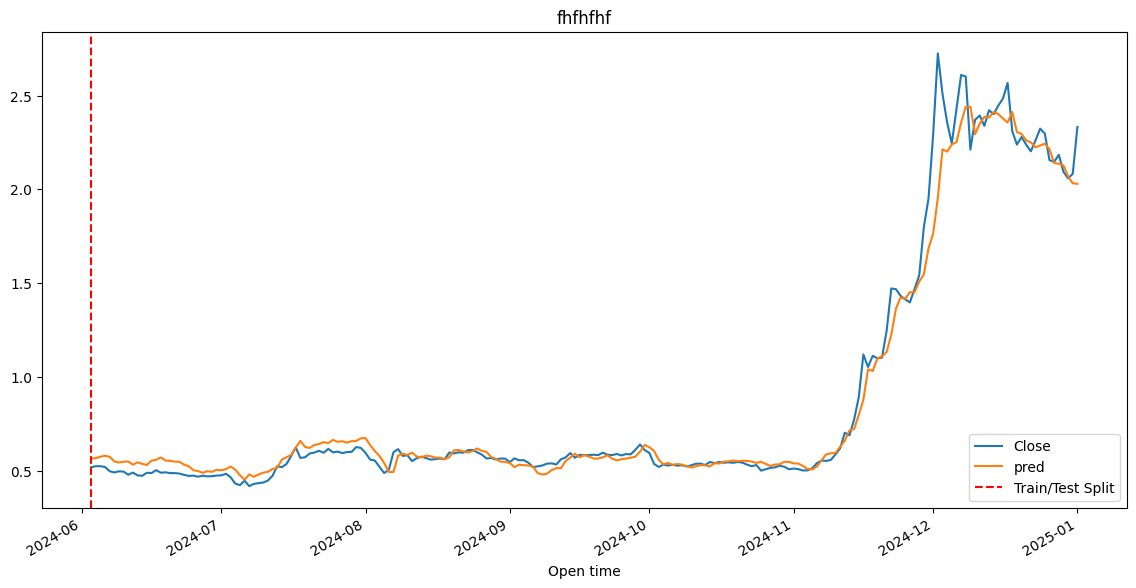

In [9]:
df["pred"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "pred"] = y_pred_inv
df[["Close", "pred"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

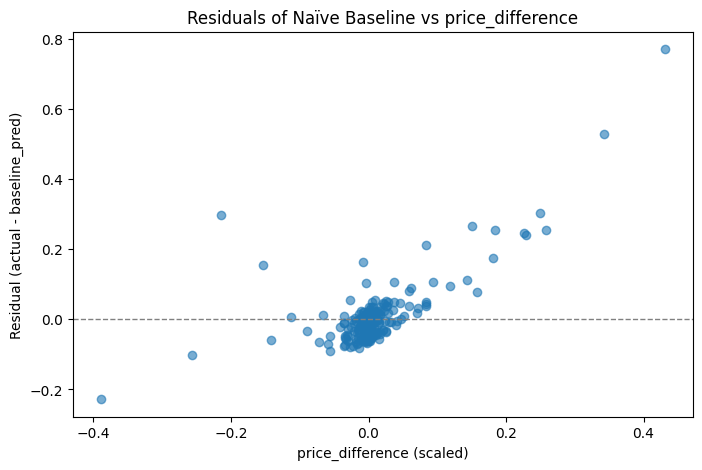

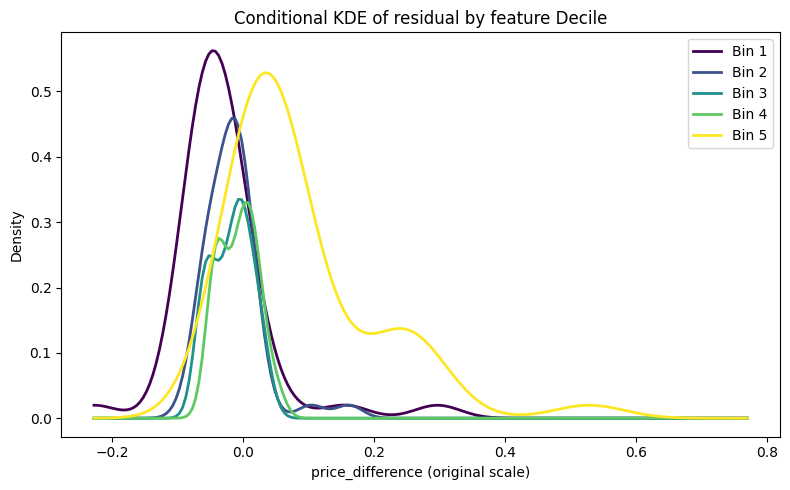

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)